In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.models import load_model
import sys
sys.path.append('../')
import os
from utils import prepare_data_single_fidelity

# Parameters
n_splits = 4
n_samples = [1000, 2000, 4000, 8000, 16000, 32000, 64000]
discretizations = ['h1']
resolutions = [60]
colors = {'h1': 'blue', 'h2': 'green', 'h3': 'red', 'h4': 'orange'}
markers = {'h1': 'o', 'h2': 's', 'h3': 'D', 'h4': '*'}
linestyles = {'h1': '-', 'h2': '--', 'h3': ':', 'h4': '-'}

# Prepare dictionary for RMSE results
rmse_test_all = {disc: [] for disc in discretizations}

# Iterate over discretizations
for discretization, resolution in zip(discretizations,resolutions):
    print(f"Processing discretization level: {discretization}")

    # Load training and test data for each discretization
    X_train, y_train, X_test, y_test = prepare_data_single_fidelity(
        115200,
        f"../data/X_train_{discretization}_60_3.csv",
        f"../data/y_train_{discretization}_60_3.csv",
        f"../data/X_test_{discretization}_60_3.csv",
        f"../data/y_test_{discretization}_60_3.csv"
    )

    for n_sample in n_samples:
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        X, y = X_train[:n_sample, :], y_train[:n_sample, :]
        rmse_test = []
        predictions_train = []
        predictions_test = []

        
        for fold_var, (train_index, val_index) in enumerate(kf.split(y), start=1):
            X_val_k = X[val_index,:]
            y_val_k = y[val_index]

            # Load model and evaluate RMSE
            model_path = f'../models/single_fidelity/resolution_{resolution}/samples_{n_sample}/model_fold_{fold_var}.keras'
            model = load_model(model_path)
            rmse_test.append(np.sqrt(np.mean((model(X_test).numpy() - y_test) ** 2)))
            predictions_train.append(model(X_train).numpy())
            predictions_test.append(model(X_test).numpy())
            
        predictions_train = np.mean(np.array(predictions_train),axis=0)
        predictions_test = np.mean(np.array(predictions_test),axis=0)

        # Define the directory path 
        output_dir = f'../data/predictions_single_fidelity/resolution_{resolution}/samples_{n_sample}/'

        # Create the directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)

        # Save the files
        np.savetxt(os.path.join(output_dir, 'predictions_train.csv'), predictions_train, delimiter=",")
        np.savetxt(os.path.join(output_dir, 'predictions_test.csv'), predictions_test, delimiter=",")

        # Append RMSE results for current sample size and discretization
        rmse_test_all[discretization].append(rmse_test)


Processing discretization level: h1


In [9]:
rmse_test_all

{'h1': [[0.04862222369807283,
   0.04882723385965949,
   0.048818307096471544,
   0.049078468742145685],
  [0.03604375212154367,
   0.03483821225521706,
   0.03603909141290731,
   0.035949877510121575],
  [0.01881711536247124,
   0.019095741453279868,
   0.01926622227639659,
   0.02049495784250743],
  [0.013900445552753934,
   0.013727955233010479,
   0.013914834609399783,
   0.013566065861447554],
  [0.00786378979015133,
   0.007661150512275866,
   0.007854516536582836,
   0.0077965194018523335],
  [0.0059773971717271565,
   0.006097781234101908,
   0.00576086173524264,
   0.005899593106840308],
  [0.0035515671028375855,
   0.0036052300849635788,
   0.0035964286117164436,
   0.003615528857787647]]}

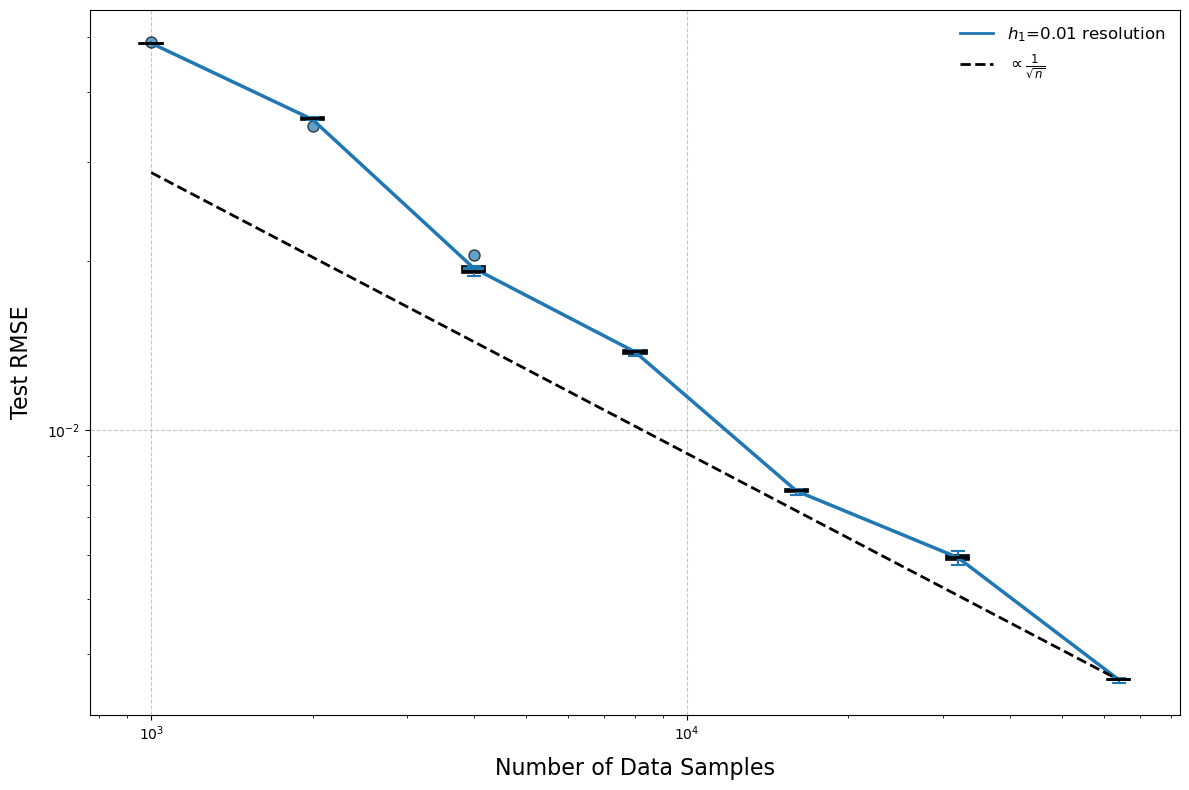

In [10]:
colors = {'h1': '#1f77b4'}  # Colorblind-friendly colors
linestyles = {'h1': '-'}
markers = {'h1': 'o'}

# Create figure with enhanced size and clarity
plt.figure(figsize=(12, 8))

# Custom legend lines
custom_lines = [plt.Line2D([0], [0], color=colors[d], lw=2, linestyle=linestyles[d]) for d in discretizations]

# Iterate over discretizations and create boxplots
for discretization in discretizations:
    positions = n_samples
    plt.boxplot(
        rmse_test_all[discretization],
        positions=positions,
        widths=np.array(n_samples) * 0.1,  # Fixed width for better spacing
        patch_artist=True,
        boxprops=dict(facecolor=colors[discretization], edgecolor='black', linewidth=1.2),
        medianprops=dict(color='black', linewidth=2),
        whiskerprops=dict(color=colors[discretization], linewidth=1.5),
        capprops=dict(color=colors[discretization], linewidth=1.5),
        flierprops=dict(marker=markers[discretization], color=colors[discretization],
                        markerfacecolor=colors[discretization], alpha=0.7, markersize=8),
        showfliers=True,
    )

# Add convergence lines for each discretization
for d in discretizations:
    pos = n_samples
    plt.plot(pos, np.mean(rmse_test_all[d], axis=1), color=colors[d], linestyle=linestyles[d], linewidth=2.5)

# Add theoretical convergence line
convergence_line = 1 * np.sqrt(64000) / np.sqrt(n_samples) * np.mean(rmse_test_all['h1'][-1])
plt.plot(n_samples, convergence_line, 'k--', linewidth=2, label=r'$\propto \frac{1}{\sqrt{n}}$')

# Plot enhancements
plt.xlabel('Number of Data Samples', fontsize=16, labelpad=10)
plt.ylabel('Test RMSE', fontsize=16, labelpad=10)
plt.legend(custom_lines + [plt.Line2D([0], [0], color='black', linestyle='--', lw=2)],
           [f'{r} resolution' for r in ['$h_1$=0.01']] + [r'$\propto \frac{1}{\sqrt{n}}$'],
           loc='upper right', fontsize=12, frameon=False)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xscale('log')
plt.yscale('log')

# Final layout adjustments and save
plt.tight_layout()
plt.savefig("../images/convergence_error_single_fidelity.png", dpi=300, bbox_inches='tight')
plt.show()